# AutoML 

Классификация



#### Описание набора данных:  

age     -  возраст: разница в 5 лет  
height(cm)   -      рост(см)  
weight(kg)  -   вес(кг)  
waist(cm)   -   талия(см) окружность талии длина  
eyesight(left)  -   зрение(слева)  
eyesight(right) -   зрение(справа)  
hearing(left)   -   слух(слева)  
hearing(right)  -   слух(справа)  
systolic    -   систолическое: артериальное давление  
relaxation  -   расслабление: артериальное давление 
fasting blood sugar -   уровень сахара в крови натощак  
Cholesterol     -   холестерин: общие  
triglyceride    -   триглицериды  
HDL     -   ЛПВП: тип холестерина  
LDL     -   ЛПНП: тип холестерина  
hemoglobin  -   гемоглобин  
Urine protein   -   белок  мочи  
serum creatinine    -   сывороточный креатинин  
AST -   АСТ: тип глутаминовой щавелевоуксусной трансаминазы  
ALT -   АЛТ: тип глутаминовой щавелевоуксусной трансаминазы  
Gtp -   ГТП: γ-ГТФ  
dental caries   -   кариес зубов  
smoking -   курение  

In [2]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics.confusion_matrix import confusion_matrix as cuml_confusion_matrix



from sklearn.svm import LinearSVC  # Используем LinearSVC для линейного ядра
from cuml.svm import SVC as cuSVC  # Используем GPU-ускоренную модель SVC
import cudf
import cupy as cp





print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset


Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/16_AutoML

Датасет: 
test.csv  train.csv


## 1) Загрузка

In [3]:

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']
print("\nПропуски:")
train_df.isnull().sum()


Размер данных:  (38984, 23)
 age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking
  35         170          85       97.0             0.9              0.9              1               1       118          78                   97          239           153   70  142        19.8              1               1.0   61  115  125              1        1
  20         175         110      110.0             0.7              0.9              1               1       119          79                   88          211           128   71  114        15.9              1               1.1   19   25   30              1        0
  45         155          65       86.0             0.9              0.9              1               1       110          80                   80          193        

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [4]:
# 2) EDA: исследование данных
def explore_data(df):
    eda_results = pd.DataFrame({
        'Missing (%)': df.isnull().mean() * 100,
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean(),
        'Median': df.median(),
        'Variance': df.var(),
        'Quantile 0.1': df.quantile(0.1),
        'Quantile 0.9': df.quantile(0.9),
        'Quartile 1': df.quantile(0.25),
        'Quartile 3': df.quantile(0.75),
    })
    return eda_results

print("EDA Анализ\n")
print(explore_data(train_df).to_string())



EDA Анализ

                     Missing (%)    Min     Max        Mean  Median     Variance  Quantile 0.1  Quantile 0.9  Quartile 1  Quartile 3
age                          0.0   20.0    85.0   44.127591    40.0   145.529573          30.0          60.0        40.0        55.0
height(cm)                   0.0  130.0   190.0  164.689488   165.0    84.410288         150.0         175.0       160.0       170.0
weight(kg)                   0.0   30.0   135.0   65.938718    65.0   166.321797          50.0          85.0        55.0        75.0
waist(cm)                    0.0   51.0   129.0   82.062115    82.0    86.989160          70.0          94.0        76.0        88.0
eyesight(left)               0.0    0.1     9.9    1.014955     1.0     0.248529           0.6           1.5         0.8         1.2
eyesight(right)              0.0    0.1     9.9    1.008768     1.0     0.243851           0.6           1.5         0.8         1.2
hearing(left)                0.0    1.0     2.0    1.0253

In [5]:
# Доля 1 в целевой переменной
target_ratio = train_df['smoking'].mean()
print(f'Доля курящих (smoking=1): {target_ratio:.2%}')

Доля курящих (smoking=1): 36.73%


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Загрузка данных
df = train_df.copy()

# Удалим строки с пропущенными значениями
df.dropna(inplace=True)

# Целевая переменная
target = 'smoking'
X = df.drop(columns=[target])
y = df[target]


# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


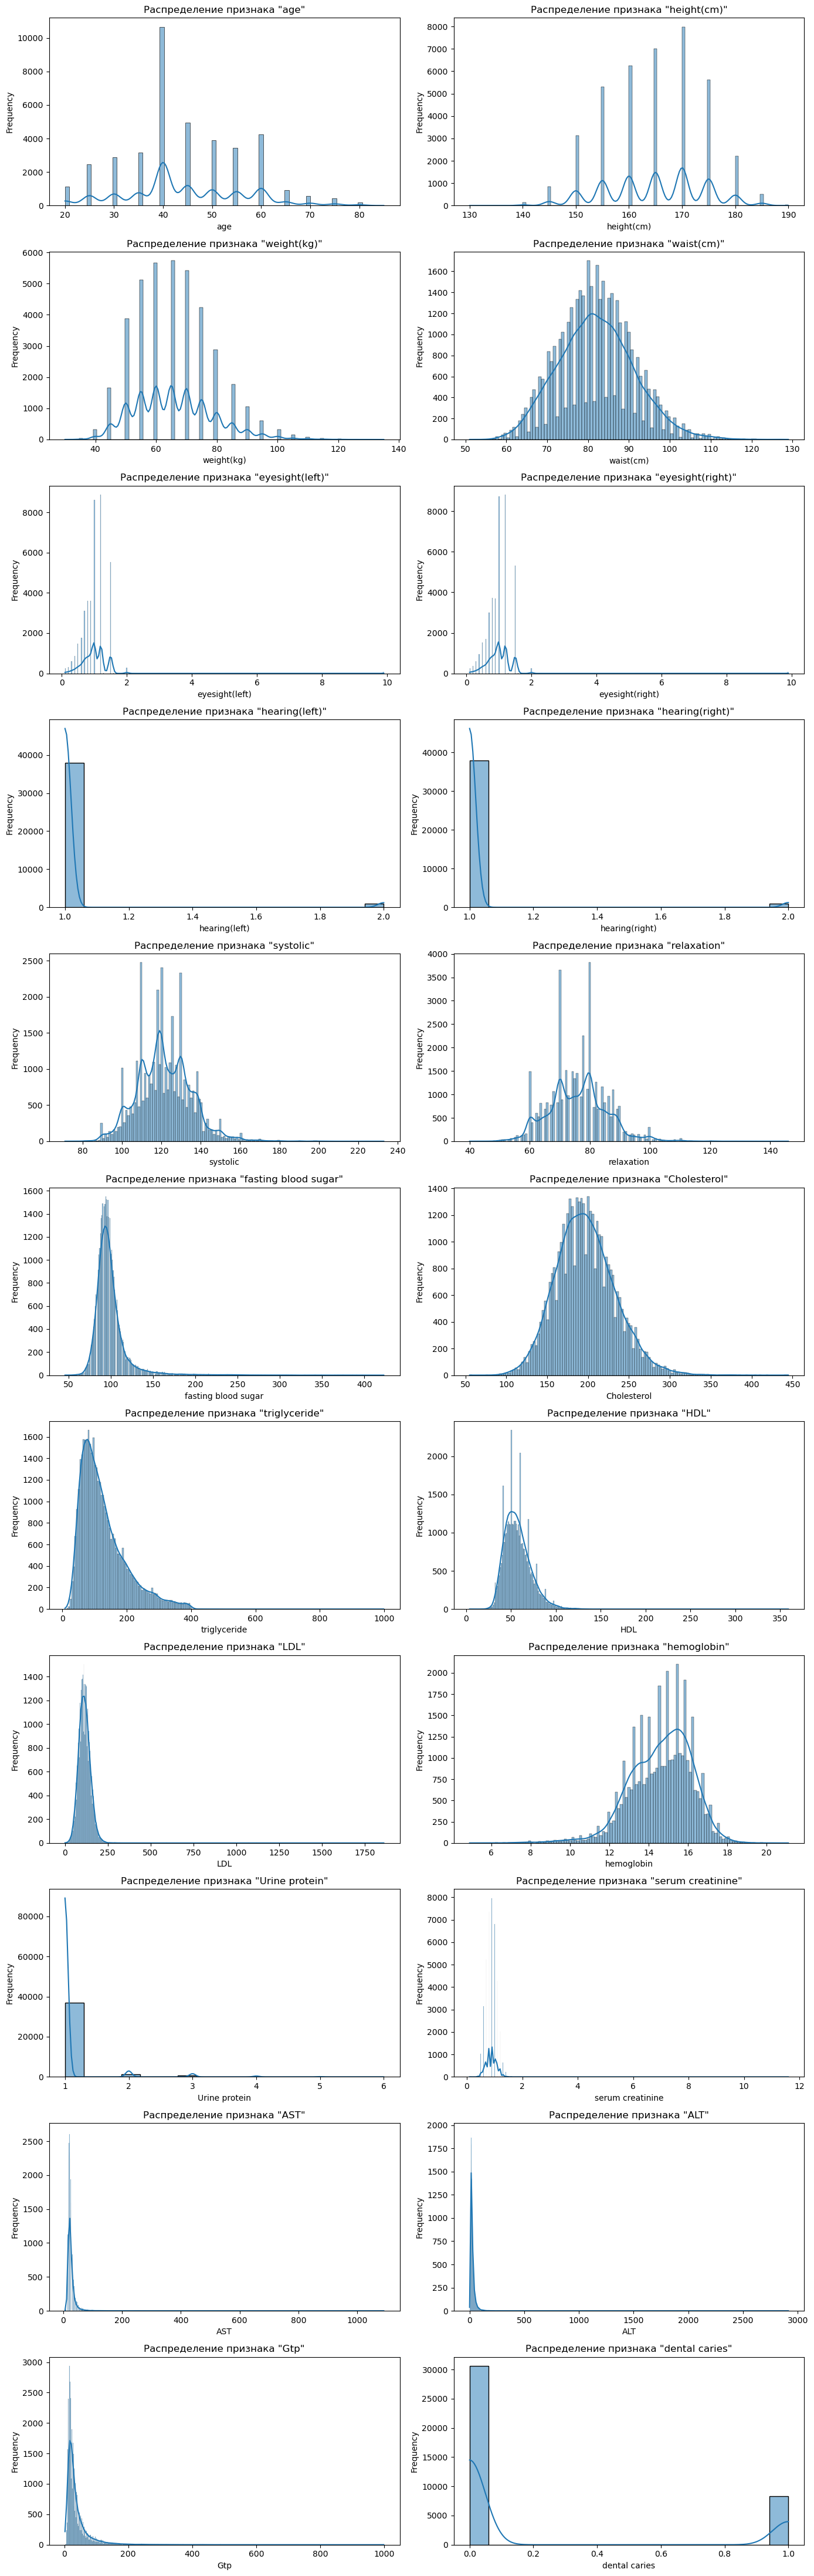

In [7]:
# Получаем список всех признаков (кроме целевой переменной)
features = X.columns

num_features = len(features)
num_rows = (num_features + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
axes = axes.flatten() 

for i, feature in enumerate(features):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение признака "{feature}"')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


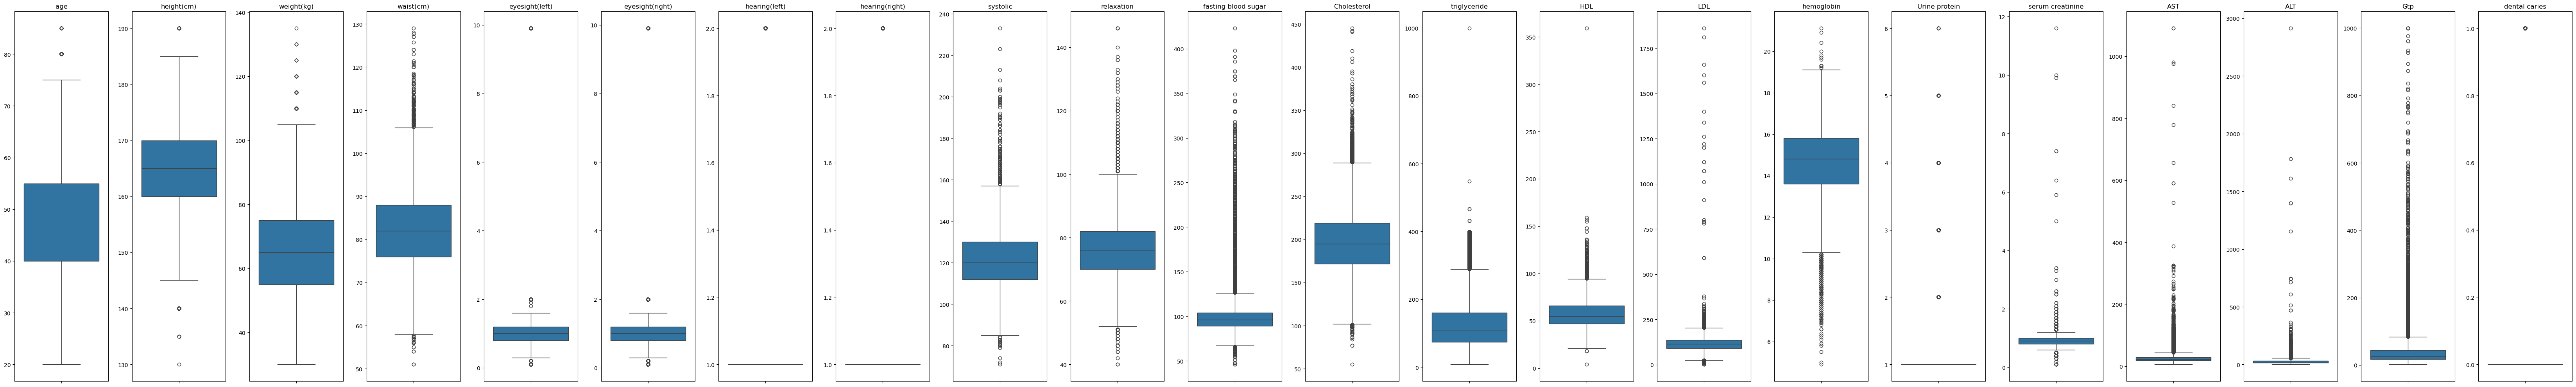

In [8]:
features = X.columns

num_features = len(features)

fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

for i, feature in enumerate(features):
    sns.boxplot(y=X[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


In [9]:
from flaml import AutoML

automl = AutoML()

automl_settings = {
    "time_budget": 300,  # Время в секундах
    "metric": 'accuracy',  
    "task": 'classification',
    "log_file_name": "flaml_classification.log",
}


automl_settings.update({
    "estimator_list": ["lgbm", "xgboost", "rf"],  # только GPU-модели
})



In [10]:
import lightgbm as lgb
import xgboost as xgb

print("[LightGBM] GPU доступен:", lgb.__version__)
print("[XGBoost] GPU доступен:", xgb.__version__)
xgb.train(
    params={"tree_method": "gpu_hist"},
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=1
)


[LightGBM] GPU доступен: 4.6.0
[XGBoost] GPU доступен: 3.0.0


/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:26:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


### AutoML 

Чтобы не обучалась долго огрничение по времени 

In [11]:
from flaml import AutoML

automl = AutoML()

automl.fit(
    X_train=X_train,
    y_train=y_train,
    task="classification",
    metric="accuracy",
    time_budget=900,
    estimator_list=["xgboost", "lgbm", "rf"],
    verbose=2,
    custom_hp={
        "xgboost": {
            "tree_method": {"domain": "hist", "init_value": "hist"},
            "device": {"domain": "cuda", "init_value": "cuda"},
        }
    }
)
print("Best model:", automl.model)

Best model: <flaml.automl.model.RandomForestEstimator object at 0x79e34d42e630>


In [12]:

print("Лучшая модель:", automl.best_estimator)
print("Лучшие hyperparameters:", automl.best_config)
print("Лучшая метрика на валидации:", 1 - automl.best_loss)


print("Все модели:", automl.classes_)


Лучшая модель: rf
Лучшие hyperparameters: {'n_estimators': 392, 'max_features': 0.23059770680288252, 'max_leaves': 3538, 'criterion': 'entropy'}
Лучшая метрика на валидации: 0.7942409946577949
Все модели: [0 1]


In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = automl.predict(X_test)

print("FLAML Accuracy:", accuracy_score(y_test, y_pred))
print("FLAML F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

results = pd.DataFrame({
    'Model': ['FLAML Best Model'],
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'F1 Score': [f1_score(y_test, y_pred, average='weighted')]
})


FLAML Accuracy: 0.8068487879953828
FLAML F1 Score: 0.807589214055542
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4975
           1       0.72      0.75      0.74      2822

    accuracy                           0.81      7797
   macro avg       0.79      0.79      0.79      7797
weighted avg       0.81      0.81      0.81      7797



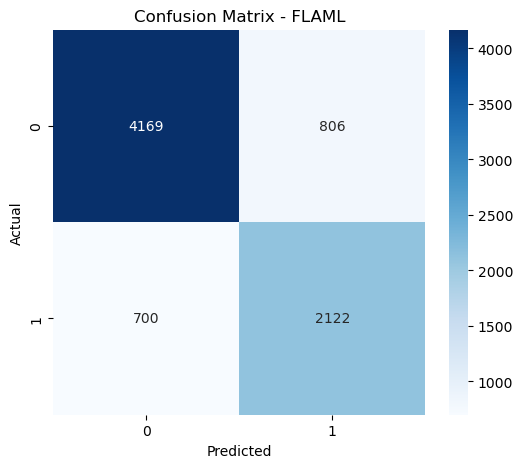

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - FLAML')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### используем  RandomForestClassifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score'])

new_row = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf)],
    'F1 Score': [f1_score(y_test, y_pred_rf, average='weighted')]
})

results = pd.concat([results, new_row], ignore_index=True)

print(results)


Random Forest Accuracy: 0.8015903552648455
Random Forest F1 Score: 0.8016735315713363
           Model  Accuracy  F1 Score
0  Random Forest   0.80159  0.801674


/tmp/ipykernel_4201/338989791.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [16]:
print(results)


           Model  Accuracy  F1 Score
0  Random Forest   0.80159  0.801674


### Сравнение

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
from flaml import AutoML
from sklearn.ensemble import RandomForestClassifier

y_pred_automl = automl.predict(X_test)

accuracy_automl = accuracy_score(y_test, y_pred_automl)
f1_automl = f1_score(y_test, y_pred_automl, average='weighted')

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

results = pd.DataFrame()

results = pd.concat([results, pd.DataFrame({
    'Model': ['FLAML Best Model'],
    'Accuracy': [accuracy_automl],
    'F1 Score': [f1_automl]
})], ignore_index=True)

results = pd.concat([results, pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_rf],
    'F1 Score': [f1_rf]
})], ignore_index=True)

print(results)



              Model  Accuracy  F1 Score
0  FLAML Best Model  0.806849  0.807589
1     Random Forest  0.801590  0.801674


### Сохранение

In [18]:

import joblib
joblib.dump(automl.model, 'best_flaml_model.pkl')


['best_flaml_model.pkl']

# 2 Задание 
Прогнозирование временных рядов

In [19]:
df = pd.read_csv('dataset1/dataset.csv')

print('\nРазмер данных: ', df.shape)

print(df.head().to_string(index=False))

print("\nПропуски:")
df.isnull().sum()


Размер данных:  (397, 2)
    DATE  IPG2211A2N
1/1/1985     72.5052
2/1/1985     70.6720
3/1/1985     62.4502
4/1/1985     57.4714
5/1/1985     55.3151

Пропуски:


DATE          0
IPG2211A2N    0
dtype: int64

In [20]:
# Преобразуем колонку DATE в формат datetime и установим ее как индекс
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Проверим результат
print(df.head())
print(df.index)

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)


In [21]:


# Добавим лаги (предыдущие значения)
df['lag_1'] = df['IPG2211A2N'].shift(1)
df['lag_2'] = df['IPG2211A2N'].shift(2)
df['lag_3'] = df['IPG2211A2N'].shift(3)

df = df.dropna()

In [22]:
# Разделим на X и y
X = df[['lag_1', 'lag_2', 'lag_3']]
y = df['IPG2211A2N']
# Обучающая и тестовая выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [23]:

# Обучающая и тестовая выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [24]:
from flaml import AutoML

automl = AutoML()
automl.fit(
    X_train=X_train,
    y_train=y_train,
    task="regression",
    metric="mse",
    time_budget=900,
    estimator_list=["xgboost", "lgbm", "rf"],
    verbose=2
)


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = automl.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MSE: 40.433531096588794
MAE: 4.77566460826246
R2: 0.5635526658280761


In [26]:
print(f'Лучшая Модель: {automl.best_estimator}\n')
print(f'Лучшие параметры:\n {automl.best_config}\n')
print(f'Лучшие данные roc_auc_ovo On Val: {1 - automl.best_loss:.4g}\n')
print(f'Лучшее время тренировки: {automl.best_config_train_time:.4g} s\n')

Лучшая Модель: xgboost

Лучшие параметры:
 {'n_estimators': 314, 'max_leaves': 15, 'min_child_weight': 0.6448991138586078, 'learning_rate': 0.16111611138830753, 'subsample': 0.3157133517046084, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.002159361876697577, 'reg_lambda': 32.26876471326405}

Лучшие данные roc_auc_ovo On Val: -20.72

Лучшее время тренировки: 0.1203 s



### Графики

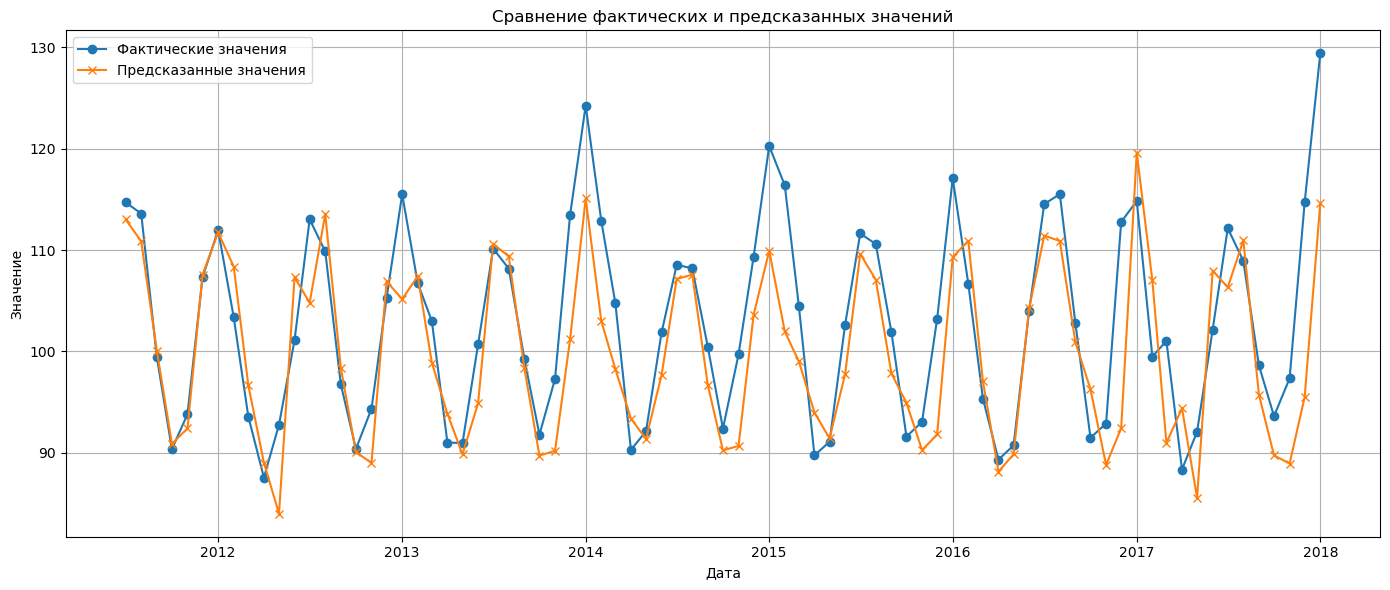

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Предсказанные значения', marker='x')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
original_dates = pd.read_csv('dataset1/dataset.csv', parse_dates=["DATE"])

dates = original_dates['DATE'].iloc[3:].reset_index(drop=True)

full_actuals = pd.concat([y_train, y_test]).reset_index(drop=True)
full_predictions = pd.Series([None] * len(y_train) + list(y_pred), index=range(len(full_actuals)))


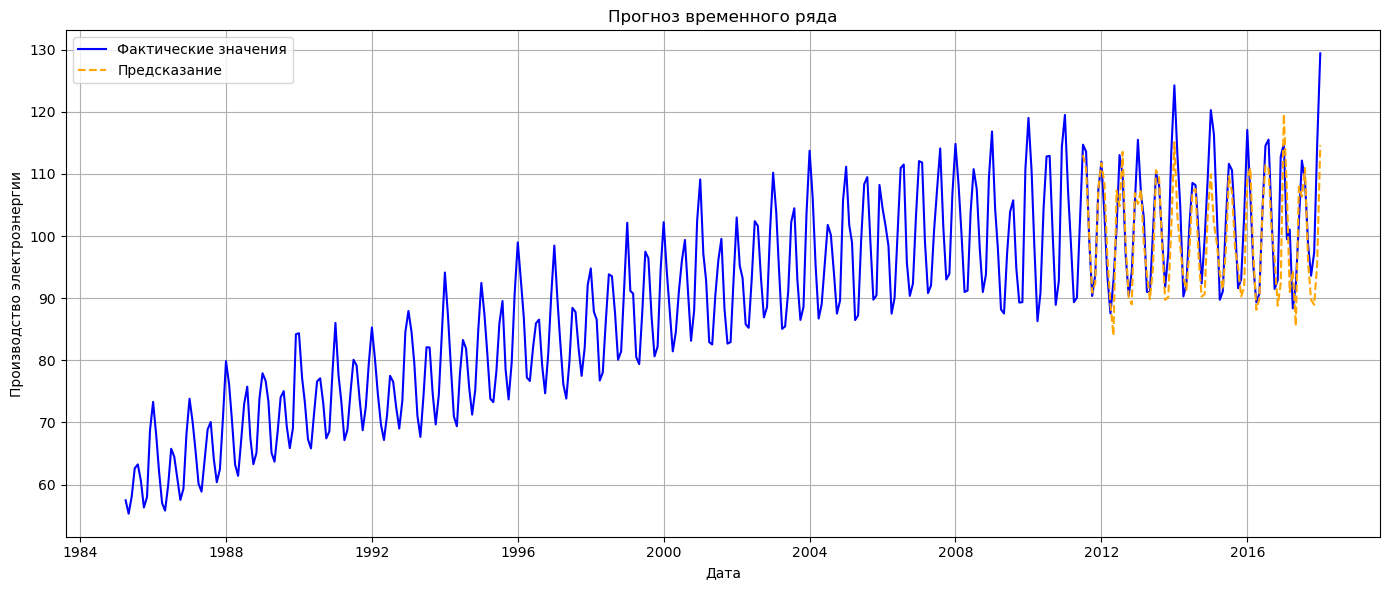

In [29]:
plt.figure(figsize=(14, 6))

plt.plot(dates, full_actuals, label='Фактические значения', color='blue')

plt.plot(dates, full_predictions, label='Предсказание', color='orange', linestyle='--')

plt.title("Прогноз временного ряда")
plt.xlabel("Дата")
plt.ylabel("Производство электроэнергии")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
loaded_model = joblib.load("best_model_flaml.pkl")
preds = loaded_model.predict(X_test)
